In [3]:
import sys 
sys.path.append('..')
from utils import wasserstein2
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

## Setting up Ring Scenario
One generated and one true target

In [1]:
# distribution params
dims = [1, 10, 100]
n_gens = [2, 5, 10]
n_true=1

In [4]:
# initializing discriminator kernel
width_params=[0.1, 0.5, 1]
# varying across training params
T = 1000
(lr_d,lr_g) = (1e-2,1e-2)
lam = 1e-1
log_interval=10

W_dist = np.zeros((len(n_gens), len(dims), len(width_params), T//log_interval))
for i, n_gen in enumerate(n_gens):
    for j, dim in enumerate(dims):
        scale = 0.2
        # X_gen_init = scale*torch.ones((n_gen,dim), dtype=torch.float32)
        gen_dist = Ring(dim,radius=scale,n_mixture=n_gen)
        X_gen_init,_ = gen_dist.sample_n(n_gen)
        print(np.linalg.norm(X_gen_init.numpy(),axis=1))
        p_gen = torch.ones(n_gen).softmax(-1)
        X_true = torch.zeros((n_true,dim), dtype=torch.float32)
        p_true = torch.ones(n_true).softmax(-1)
        for k, width_param in enumerate(width_params):
            # init discriminator
            DK = Kernel('gaussian', width_param=width_param)
            D = KernelDiscriminator(DK, dim, lam, lr_d)
            # init gen points
            G = PointGenerator(X_gen_init, p_gen)
            # find generated trajectories
            model = KernelGAN(G, D, device)
            model.train(X_true, p_true, lr_d, lr_g, T, lam)
            # calculate w2 distances
            curr_w2 = wasserstein2(model.G.X_gen.detach().cpu(), X_true.detach().cpu(), log_interval)
            W_dist[i, j, k, :] = curr_w2


[0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 1710.83it/s]


[0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 1629.18it/s]


[0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 1374.64it/s]


[0.2 0.2 0.2 0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 1482.47it/s]


[0.2 0.2 0.2 0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 912.37it/s]


[0.19999999 0.2        0.20000002 0.19999999 0.2       ]


100%|██████████| 100/100 [00:00<00:00, 922.07it/s]


[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 1487.54it/s]


[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 862.36it/s]


[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]


100%|██████████| 100/100 [00:00<00:00, 906.21it/s]


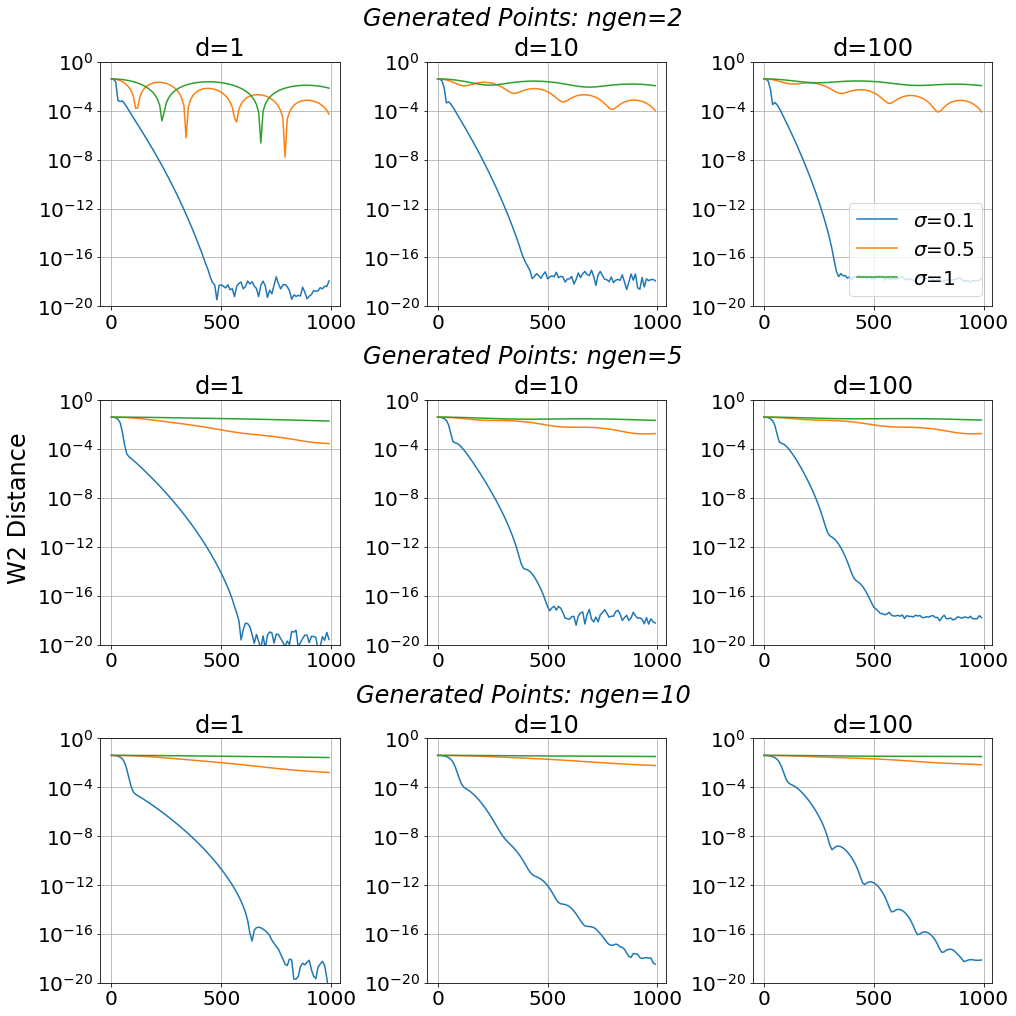

In [5]:
fig = plt.figure(figsize=(14,14), constrained_layout=True)
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'Generated Points: ngen={n_gens[row]}', style='italic')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        for k, width_param in enumerate(width_params):
            ax.semilogy(list(range(0,T,log_interval)), W_dist[row,col,k,:], c=f'C{k}', label=f'$\sigma$={width_param}')
            ax.set_ylim((10**-20,10**0))
        ax.grid()
        ax.set_title(f'd={dims[col]}')
        ax.plot()
        if row==0 and col==2:
            ax.legend(loc='lower right')
fig.supylabel('W2 Distance')
plt.savefig(f"../data/ngen_and_dimensions.png", format='png', bbox_inches='tight')